In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from scipy import stats

from IPython.display import Image

import sys
from math import sqrt

In [53]:
from sklearn.datasets import load_boston
print(load_boston()['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Зависимая переменная MEDV  уже представляет собой медиану / среднюю стоимость недвижимости, значит каждая строка/  наблюдение Датасета представляет собой НЕ показатель отдельного прецедента / сделки,  а уже обобщенную / усредненную / сглаженную характеристику группы частных наблюдений, вошедших в расчет медианы.

Принимая во внимание малый размер выборки, анализ датасета предполагает более ответственное отношение к выбросам / нестандартным значениям, поскольку за каждым стоит уже не прецедент, а явление.

In [4]:
data = pd.read_csv(load_boston()['filename'], skiprows=1)
data.head(1)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24.0


In [5]:
data.isna().sum().sum()
d= data.drop_duplicates(inplace = False)
data.describe().round(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53
std,8.60,23.32,6.86,0.25,0.12,0.70,28.15,2.11,8.71,168.54,2.16,91.29,7.14,9.20
min,0.01,0.00,0.46,0.00,0.38,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.02,2.10,4.00,279.00,17.40,375.38,6.95,17.02
50%,0.26,0.00,9.69,0.00,0.54,6.21,77.50,3.21,5.00,330.00,19.05,391.44,11.36,21.20
75%,3.68,12.50,18.10,0.00,0.62,6.62,94.07,5.19,24.00,666.00,20.20,396.22,16.96,25.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


Очевидны аномальные значения по полям CRIM, ZN, AGE, B - уже по разнице между мин/макс и ближним квартилем: 

Уровень преступности более 50% представляется неправдоподобным.

Вполне правдоподобно: Земли ИЖС одного района вполне могут быть заполнены только крупными земельными участками
Все строения одного района вполне могут быть построены позже 1940 года. Доля афроамериканцув может быть какой угодно


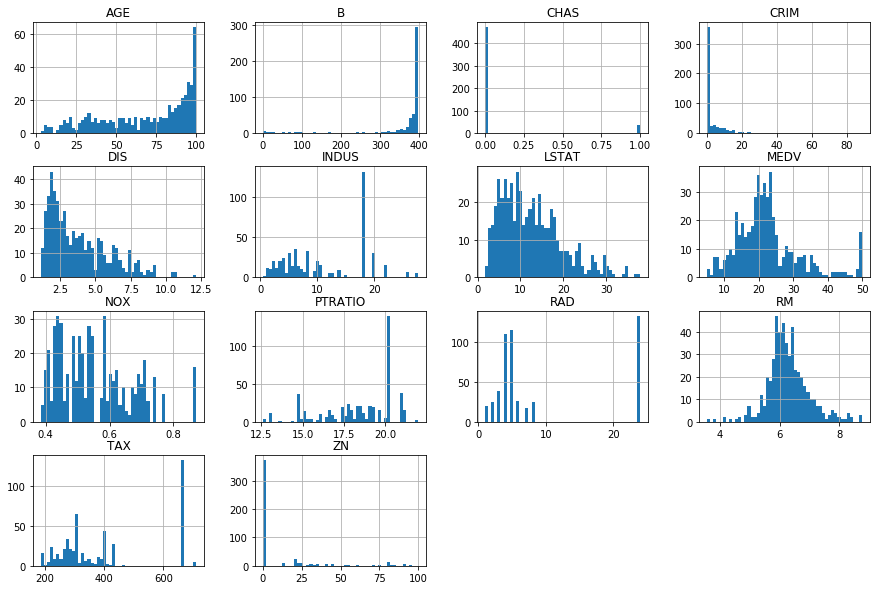

In [8]:
data.hist(figsize=(15,10), bins=50)
#data.hist(figsize=(50,30))
plt.show()

Обращаем внимание:

- зависимая переменная MEDV  распределена в целом нормально, но при значениях > 40  (=50) дает выброс / или другую логику распределения

- распределения переменных TAX и RAD отчетливо поделены на 2 группы  

(14.0, 0.0)

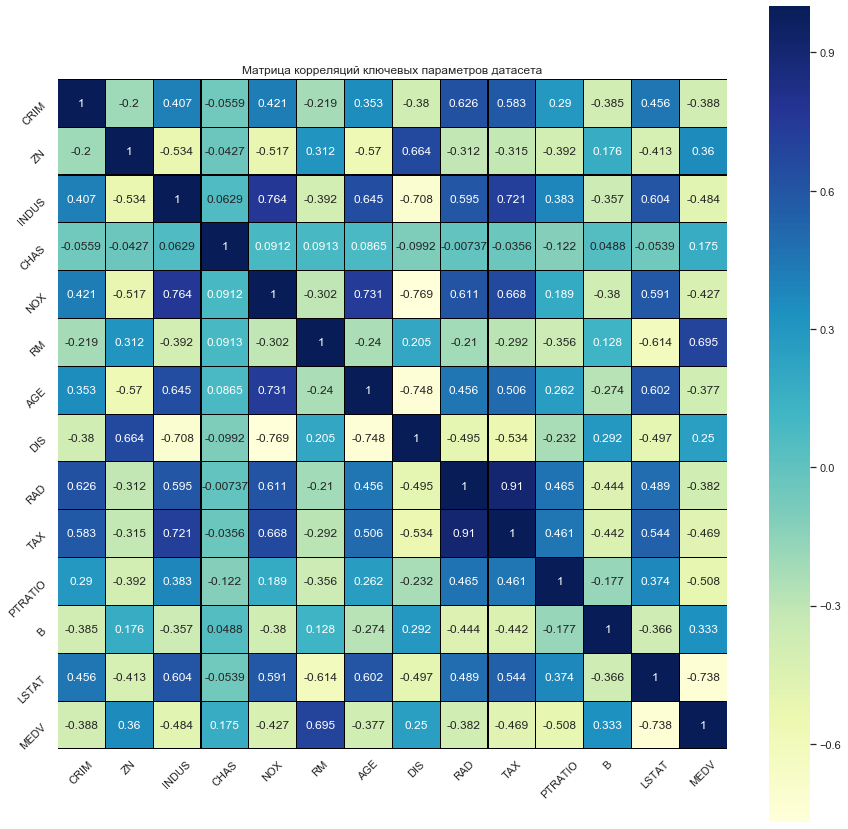

In [9]:
m_corr = data.corr()
sns.set(rc={'figure.figsize':(15,15)})

ax = sns.heatmap(m_corr,  
                annot = True, 
                fmt='.3g', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black', 
                square=True)

plt.title('Матрица корреляций ключевых параметров датасета')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

В связках переменных "Независимая - Независимая"  значимы  корелляции:
 - (0.91) между TAX (налоговой ставкой) и RAD (удаленностью от автомагистралей)
 - (0.721) TAX и INDUS - чем меньше торговой недвижимости (больше промышленности и складов) тем больше ставка налога  
 - (+\-0.764) INDUS и NOX и DIS - чем меньше торговой недвижимости (больше промышленности и складов) тем хуже воздух,  и выше спрос на центры занятости
 
В связках переменных "Зависимая - Независимая" - высокий уровень корелляции у MEDV (стоимость недвижимост) и LSTAT (уровень бедности) (-0,738),   MEDV и RM (количество комнат) (0,695) 

Матрица корреляций вполне вписывается в мою (внутреннюю) логику и ничему сильно не противоречит

Выдвигаю гипотезу:

Один из следующих показателей TAX или ZN разбивает выборку наблюдений на 2 разные группы, которые качественно разно ведут себя по отношению к средней стоимости недвижимости.
Оценим статистические различия погруппам каждого из показателей:

Ttest_indResult(statistic=10.245571179112012, pvalue=1.6682534909418863e-22)


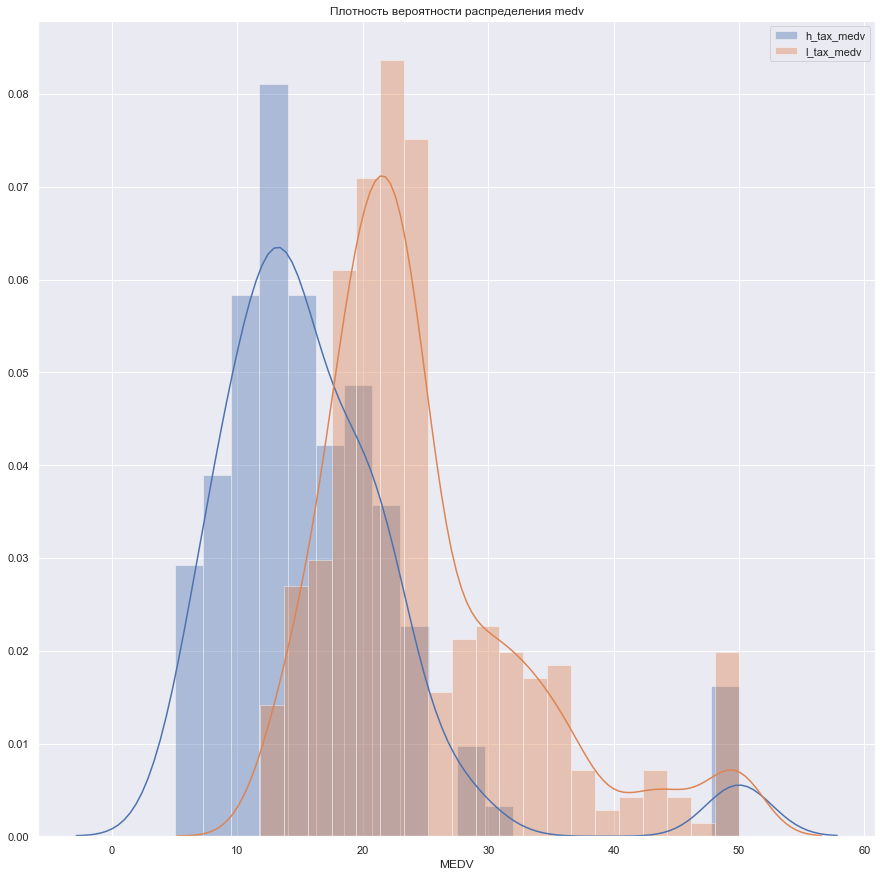

In [135]:
# Tax 
h_tax_medv = data[data['TAX']>=666]['MEDV']
l_tax_medv = data[data['TAX']<666]['MEDV']

print(stats.ttest_ind(l_tax_medv, h_tax_medv))

sns.distplot(h_tax_medv, 20)
sns.distplot(l_tax_medv, 20)
plt.title('Плотность вероятности распределения medv')
plt.legend(['h_tax_medv', 'l_tax_medv'])
plt.show()

Ttest_indResult(statistic=-9.038052720156845, pvalue=3.4198250341754156e-18)


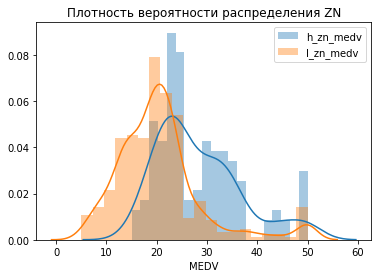

In [13]:
# ZN 
h_zn_medv = data[data['ZN']>=1]['MEDV']
l_zn_medv = data[data['ZN']<1]['MEDV']

print(stats.ttest_ind(l_zn_medv, h_zn_medv))

sns.distplot(h_zn_medv, 20)
sns.distplot(l_zn_medv, 20)
plt.title('Плотность вероятности распределения ZN')
plt.legend(['h_zn_medv', 'l_zn_medv'])
plt.show()

Статистические различия между группами по показателю TAX в рамках влияния на MEDV ,более очевидны, распределение каждой из групп ближе к нормальному, развиваем гипотезу о том, что различные группы по уровню показателя TAX  по разному влияют на цену недвижимости. Рассмотрим каждую из групп:

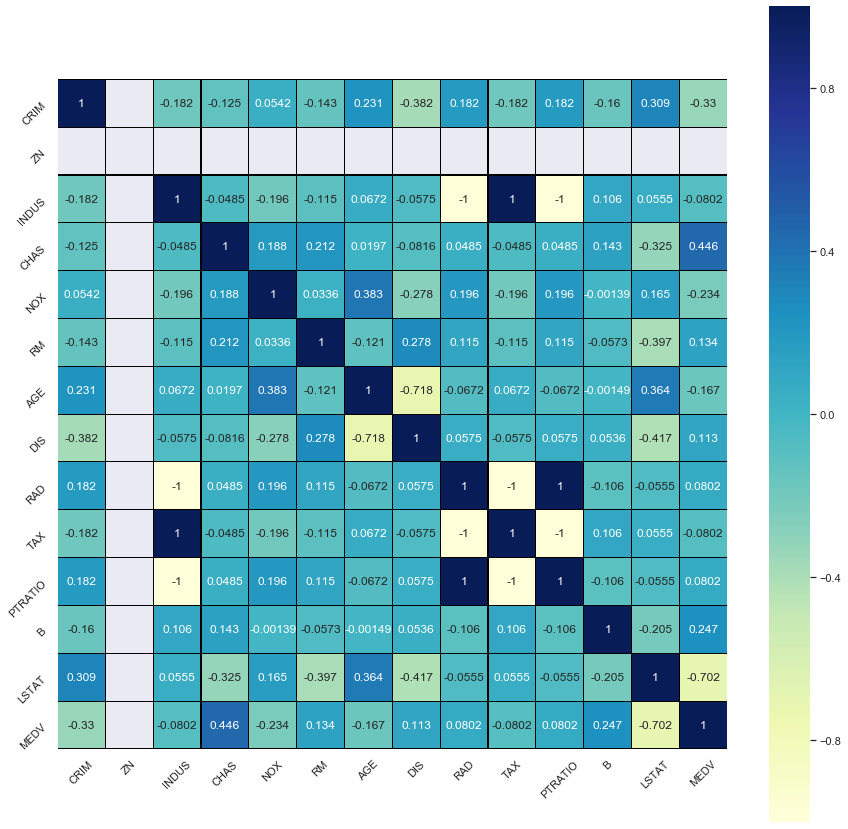

In [21]:
ht_corr = data[data['TAX']>=666].corr()

hi_tax.set_title('Высокий уровень налогов')
sns.set(rc={'figure.figsize':(15,15)})
hi_tax = sns.heatmap(ht_corr,  
                annot = True, 
                fmt='.3g', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black', 
                square=True)
i1, k1 = hi_tax.get_ylim()
hi_tax.set_ylim(i1+0.5, k1-0.5)

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

(14.0, 0.0)

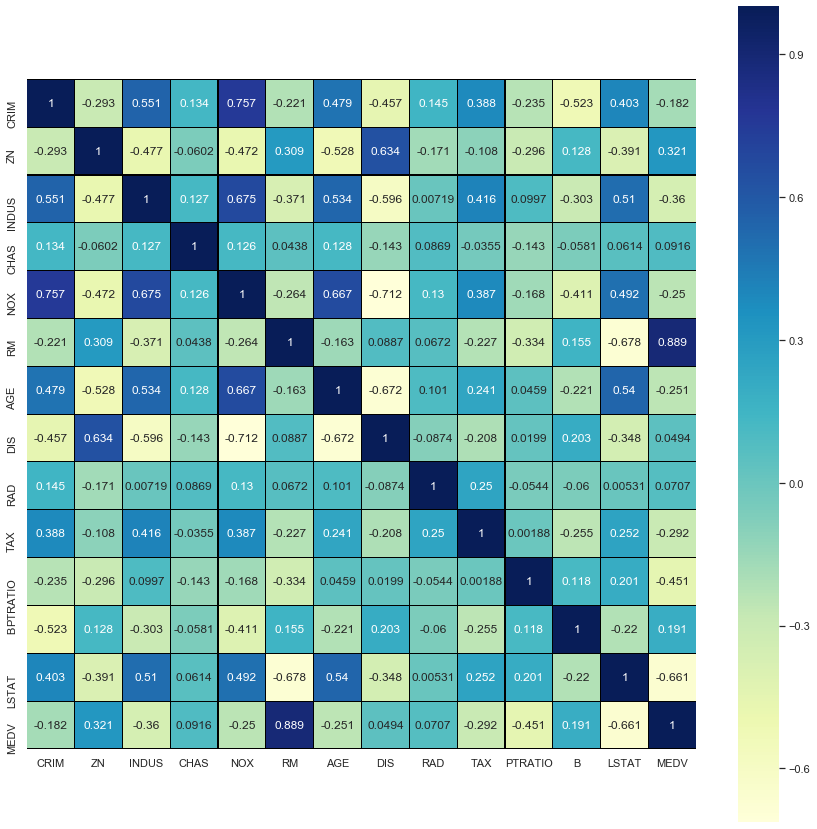

In [22]:
lt_corr = data[data['TAX']< 666].corr()
low_tax.set_title('Низкий уровень налогов')
sns.set(rc={'figure.figsize':(15,15)})
low_tax = sns.heatmap(lt_corr,  
                annot = True, 
                fmt='.3g', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black', 
                square=True)
i2, k2 = low_tax.get_ylim()
low_tax.set_ylim(i2+0.5, k2-0.5)

Видим, по 2 группам наблюдений показатели корреляции качественно отличаются,  соответственно выдвигаем гипотезу, что модели логистической регрессии в рамках предсказания показателя MEDV, построенные в отношении групп наблюдений с высокими и низким налогами будут работать лучше, нежели все наблюдения в единой модели

In [69]:
def regress_test (d, feature_col, y_col=13, w=1):
    X = d.iloc[:,feature_col]
    y = d.iloc[:,[y_col]]
    reg = LinearRegression().fit(X, y)
    pred_values = reg.predict(X)
    if w == 1:
        print('Weights: {}'.format(reg.coef_))
        print('Bias: {}'.format(reg.intercept_))
        print('Error: {}'.format(mean_absolute_error(pred_values, y)))
    else:
        return pred_values

In [70]:
# Полная выборка данных
regress_test( data,  [0,1,2,3,4,5,6,7,8,9,10,11,12])

Weights: [[-1.08011358e-01  4.64204584e-02  2.05586264e-02  2.68673382e+00
  -1.77666112e+01  3.80986521e+00  6.92224640e-04 -1.47556685e+00
   3.06049479e-01 -1.23345939e-02 -9.52747232e-01  9.31168327e-03
  -5.24758378e-01]]
Bias: [36.45948839]
Error: 3.270862810900314


In [39]:
# Выборка данных с низкими налогами 
regress_test(data[(data['TAX']<=666)],  [0,1,2,3,4,5,6,7,8,9,10,11,12])

Weights: [[-1.06878308e-01  4.68305394e-02  1.20688794e-02  2.66573268e+00
  -1.69820801e+01  3.77775525e+00  9.27657778e-04 -1.46569302e+00
   3.54301531e-01 -1.50192943e-02 -9.54684090e-01  9.16686085e-03
  -5.28365016e-01]]
Bias: [36.99482546]
Error: 3.2787512129345373


In [40]:
# Выборка данных с высокими налогами / полная
regress_test(data[(data['TAX']>666)],  [0,1,2,3,4,5,6,7,8,9,10,11,12])

Weights: [[-9.44319577e-01  4.44089210e-16  6.66133815e-16 -1.77635684e-15
   0.00000000e+00  8.05783079e+00 -7.85070615e-01  3.98122409e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.65402940e-01
   1.75234260e+00]]
Bias: [-99.58366892]
Error: 1.0658141036401503e-14


In [41]:
# Выборка данных с высокими налогами / за вычетом 
# показателей, подверженных избыточной корелляции (ZN, INDUS, TAX, PTRATIO)
regress_test(data[(data['TAX']>666)], [0,3,4,5,6,7,8,11,12])

Weights: [[-9.44319577e-01 -2.22044605e-15 -1.55431223e-15  8.05783079e+00
  -7.85070615e-01  3.98122409e+00  0.00000000e+00  2.65402940e-01
   1.75234260e+00]]
Bias: [-99.58366892]
Error: 8.526512829121202e-15


Гипотеза подтвердилась полностью на выборке данных с большими налогами (средняя ошибка модели регрессии практически сведена к нулю, более того, выявлено 4 избыточных показателя без которых модель работает  (немного, но ) лучше.

Вместе с тем, на группе данных с низким налогами гипотеза не подтверждается.

Гипотеза следующая: Распределение показателя MEDV имеет сходство с нормальным распределением за некоторым исключением 

количество наблюдений за рамками нормального распределения 16


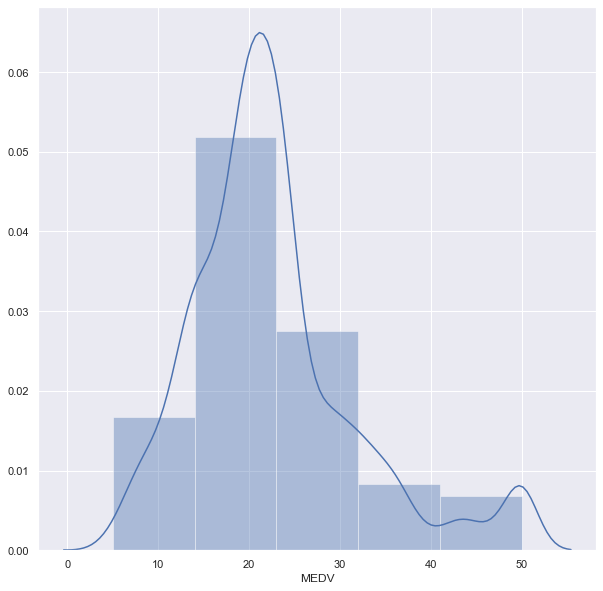

In [52]:
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(data['MEDV'], 5)
print('количество наблюдений за рамками нормального распределения', data[data['MEDV']>=50].shape[0])

In [51]:
regress_test(data[(data['TAX']<666) & (data['MEDV']<50)],[0,1,2,3,4,5,6,7,8,9,10,11,12])

Weights: [[ 0.50946474  0.02019873 -0.03159018  0.36357363 -4.61147792  8.27305116
  -0.05502437 -0.91243013  0.30906871 -0.01452344 -0.5809335   0.01219779
  -0.04842348]]
Bias: [-9.39540753]
Error: 2.1545757367803025


Если 16 наблюдений (не вписывающихся в нормальное распределение) выбросить совсем то средняя ошибка модели существенно снизится с 3.27 до 2.15

В распределении определенно настораживает некоторая условность / кратность 5 контрольных значений по полю MEDV, минимум = 5, макс = 50, квартиль 75% = 25 и т д) - такой правильности и кратности по жизни быть не может

In [68]:
data['MEDV_pred'] = regress_test (data, [0,1,2,3,4,5,6,7,8,9,10,11,12], w=0)
data.loc [(data['MEDV']<50), 'MEDV_pred'] = data['MEDV']
data[data['MEDV']==50].tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,MEDV_pred
368,4.89822,0.0,18.1,0,0.631,4.970,100.0,1.3325,24,666,20.2,375.52,3.26,50.0,23.800729
369,5.66998,0.0,18.1,1,0.631,6.683,96.8,1.3567,24,666,20.2,375.33,3.73,50.0,32.644074
370,6.53876,0.0,18.1,1,0.631,7.016,97.5,1.2024,24,666,20.2,392.05,2.96,50.0,34.606840
371,9.23230,0.0,18.1,0,0.631,6.216,100.0,1.1691,24,666,20.2,366.15,9.53,50.0,24.943313
372,8.26725,0.0,18.1,1,0.668,5.875,89.6,1.1296,24,666,20.2,347.88,8.88,50.0,25.999809


In [73]:
regress_test(data[(data['TAX']<666)], [0,1,2,3,4,5,6,7,8,9,10,11,12], y_col=14)

Weights: [[-1.05096907e-01  3.73539364e-02 -2.26211443e-02  1.21329174e+00
  -1.36766846e+01  3.83782068e+00 -1.83564881e-02 -1.25027962e+00
   2.55461687e-01 -1.31855660e-02 -8.69145357e-01  8.16202314e-03
  -3.85101023e-01]]
Bias: [32.6511574]
Error: 2.7488247770354794


In [85]:
regress_test(data, [0,1,2,3,4,5,6,7,8,9,10,11,12], y_col=14)

Weights: [[-7.94428202e-02  2.93696249e-02 -1.05284524e-01  1.60932918e+00
  -1.24739323e+01  4.06601645e+00 -2.17218964e-02 -1.26418836e+00
  -8.10541032e-01  7.69357838e-03 -3.78946021e-01]]
Bias: [27.78897353]
Error: 2.803327985168118


В целом по датасету замена значений в поле MEDV  = 50, на значения предсказанные моделью дает увеличение информативности модели, на выборке наблюдений с малыми налогами, наоборот искажение возрастает.